In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from model import RedCNN
from customDataset import CatdogDataset
import cv2
from misc import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import statistics
from PIL import Image
from IPython.display import display
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [12]:
gtpath="../dogData_60/gt/"
gtfiles=[]
for folder, subfolder, filenames in os.walk(gtpath):
    for files in filenames:
        gtfiles.append(files)
        

noisepath="../dogData_60/noise/"
noisefiles=[]
for folder, subfolder, filenames in os.walk(noisepath):
    for files in filenames:
        noisefiles.append(files)
        
#check whether both noise and gt have same files
print(gtfiles==noisefiles)
gtfiles_=gtfiles[:1000]

True


In [13]:
dogdataset= CatdogDataset(data_path=noisepath,target_path=gtpath,filenames=gtfiles_)
train_size=int(0.7*len(dogdataset))
test_size=len(dogdataset)-train_size
trainset,testset=random_split(dogdataset,[train_size,test_size],generator=torch.manual_seed(42))


In [14]:
ewcmodel=RedCNN()
ewcmodel.load_state_dict(torch.load("./saved_models/task1_model.pth.tar"))
print(ewcmodel)
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(ewcmodel.parameters(), lr=0.0001)

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_output): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [15]:
##Training
optimizer.zero_grad()
ewc_lambda=50000

param_dict=torch.load("./saved_fisherinfo/task1_param_dict.pth.tar")
fisher_dict=torch.load("./saved_fisherinfo/task1_fisher_dict.pth.tar")

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)


losses_batch=[]
trained_psnr=[]
psnr=[]

for epoch in range(3):
    
    for i, data in enumerate(train_loader):

        inputt, target=data

        target_pred=ewcmodel(inputt)

        img=inputt.detach().numpy()
        img_gt=target.detach().numpy()
        recon_image=target_pred.detach().numpy()

        for j in range(len(target)):
            psnr.append(cv2.PSNR(img[j],img_gt[j]))
            trained_psnr.append(cv2.PSNR(img[j],recon_image[j]))

        loss=criterion(target_pred,target)
        print(loss)

        for name, param in ewcmodel.named_parameters():
            fisher=fisher_dict[name]
            theta_star=param_dict[name]
            dm=(param-theta_star).pow(2)
            loss+=(fisher*dm).sum()*ewc_lambda



        print(loss)
        losses_batch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i%5==0):
            print(f"Epoch:{epoch+1} Loss:{loss.item()} Batch:{i}")




tensor(1338.5024, grad_fn=<MseLossBackward0>)
tensor(1338.5024, grad_fn=<AddBackward0>)
Epoch:1 Loss:1338.50244140625 Batch:0
tensor(1249.0714, grad_fn=<MseLossBackward0>)
tensor(1252.0668, grad_fn=<AddBackward0>)
tensor(1245.4390, grad_fn=<MseLossBackward0>)
tensor(1251.7686, grad_fn=<AddBackward0>)
tensor(1178.8094, grad_fn=<MseLossBackward0>)
tensor(1188.7395, grad_fn=<AddBackward0>)
tensor(1237.2289, grad_fn=<MseLossBackward0>)
tensor(1251.1627, grad_fn=<AddBackward0>)
tensor(1163.5872, grad_fn=<MseLossBackward0>)
tensor(1181.5756, grad_fn=<AddBackward0>)
Epoch:1 Loss:1181.5755615234375 Batch:5
tensor(1174.1107, grad_fn=<MseLossBackward0>)
tensor(1196.0436, grad_fn=<AddBackward0>)
tensor(1121.7076, grad_fn=<MseLossBackward0>)
tensor(1147.4646, grad_fn=<AddBackward0>)
tensor(1109.2810, grad_fn=<MseLossBackward0>)
tensor(1138.7992, grad_fn=<AddBackward0>)
tensor(1095.4598, grad_fn=<MseLossBackward0>)
tensor(1128.6438, grad_fn=<AddBackward0>)
tensor(1057.9420, grad_fn=<MseLossBackward

In [18]:
trained_psnrfile="./psnr_data/task2ewc_by_task2ewc_trainfiles.pth.tar"
psnr_file="./psnr_data/task2ewc_trainfiles.pth.tar"
loss_file="./saved_loss/task2ewc_loss.pth.tar"

torch.save(trained_psnr,trained_psnrfile)
torch.save(psnr,psnr_file)
torch.save(losses_batch,loss_file)

modelfile="./saved_models/task2ewc_model.pth.tar"

torch.save(ewcmodel.state_dict(),modelfile)

# Model Diagnostics

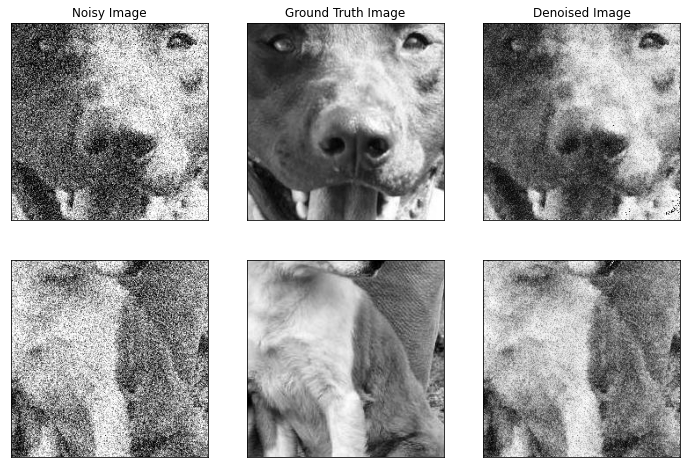

In [19]:
check_images(trainset[110],testset[9],ewcmodel)

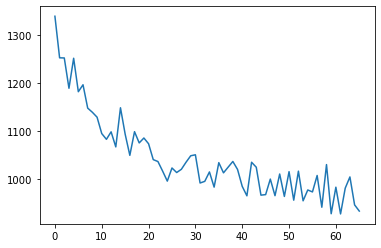

In [20]:
#plopling the loss vs batch
losses_batch=torch.load("./saved_loss/task2ewc_loss.pth.tar")
plt.plot(list(range(66)),losses_batch)

In [21]:
##PSNR of training data
print(f"PSNR Training Set: {statistics.mean(psnr)}")
print(f"PSNR after applying the model: {statistics.mean(trained_psnr)}")

PSNR Training Set: 13.381423840721473
PSNR after applying the model: 20.011102914061375


In [22]:
##PSNR of test data
test_psnrfile="./psnr_data/task2ewc_testfiles.pth.tar"
test_modelpsnrfile="./psnr_data/task2ewc_by_task2ewc_testfiles.pth.tar"

test1_psnr=gt_psnr(testset)
test_modelpsnr=test_psnr(testset,ewcmodel)

torch.save(test1_psnr,test_psnrfile)
torch.save(test_modelpsnr,test_modelpsnrfile)

PSNR test set: 13.361490453879417
PSNR after model: 13.735618713993977
